# Part 1) Introduction to Kalman Filter

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm  # optional for PDFs or confidence intervals

## 1.1 - Why Do Kalman Filters Exist?

**<ins>What problem were Kalman filters trying to solve?</ins>**

In real-world systems — like satellites, aircraft, self-driving cars, and even phones — we often want to know something important about the system’s state. For example:

- A spacecraft’s position and velocity
- An aircraft’s pitch or roll angle
- A robot’s location on a map

But here’s the problem:

We can’t measure the state perfectly.  
Sensors are noisy.  
Our mathematical models are not perfect either.  
We only get measurements at discrete time intervals.

So we face two big challenges:

1. **Estimating the current state when we can't see it directly**
2. **Filtering out the noise from measurements to make good decisions**

<ins>What the Kalman filter solves</ins>:

The Kalman Filter (KF) provides a mathematical way to:

- Predict the system’s next state using a model (e.g., physics equations)
- Update the prediction using real sensor measurements
- Combine both optimally, by weighting each source of information based on how much noise or uncertainty it contains

It does all this recursively, in real time, and with minimal memory.

**<ins>Why it's so important</ins>**:

- It's computationally efficient (only needs the current state and the latest measurement)
- It gives the best possible estimate under Gaussian noise assumptions
- It’s foundational in control systems, navigation, GNSS, robotics, computer vision, and more

In short: The Kalman filter helps us know what’s really going on when all we have is noisy, partial, or uncertain data.

## 1.2 - Basic Statistics

### 1.2.1 - Mean, Expected Value, Variance, Standard Deviation

#### Descriptive Stats

For example, we have 10-value list as the **entire population**, so we can compute for **descriptive statistics** that will describe the trend within the population.

Take note of the `ddof` parameter when using numpy:

- Use `ddof=0` to divide by $N$, not $N - 1$
- This gives the **true variance** and **standard deviation** of the dataset

If we later treat the same dataset as a **sample** from a larger population, we would compute **inferential statistics** instead, using $ddof=1$ to divide by $N - 1$ (Bessel’s correction).

The **mean** of a population is:

$$
\mu = \frac{1}{N} \sum_{i=1}^{N} x_i
$$

The **population variance** is:

$$
\sigma^2 = \frac{1}{N} \sum_{i=1}^{N} (x_i - \mu)^2
$$

The **population standard deviation** is:

$$
\sigma = \sqrt{\sigma^2}
$$

In [2]:
# Step 1: Define a simple dataset
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Step 2: Compute descriptive statistics
mean = np.mean(data)
variance = np.var(data, ddof=0)     
std_dev = np.std(data, ddof=0)       

print("Data:       ", data)
print("Mean:       ", mean)
print("Variance:   ", variance)
print("Std Dev:    ", std_dev)

Data:        [0 1 2 3 4 5 6 7 8 9]
Mean:        4.5
Variance:    8.25
Std Dev:     2.8722813232690143


Since this dataset is a **complete population**, the computed mean:

$$
\mu = \frac{1}{10} \sum_{i=0}^{9} x_i = 4.5
$$

is **exactly equal** to the expected value:

$$
\mathbb{E}[X] = 4.5
$$

In general, $\mathbb{E}[X]$ is a theoretical average over all possible values a random variable $X$ can take. If we only have a sample, then the sample mean is just an **estimate** of this expected value.

#### Inferential Stats

Now we treat the same dataset as a **sample** drawn from a larger population.  
This allows us to compute **inferential statistics**, which are used to estimate the characteristics of the full population.

Take note of the `ddof` parameter when using numpy:

- Use `ddof=1` to divide by $N - 1$, not $N$
- This applies **Bessel’s correction**, which corrects the bias in estimating population variance from a sample

The **sample mean** is:

$$
\bar{x} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

The **sample variance** is:

$$
s^2 = \frac{1}{n - 1} \sum_{i=1}^{n} (x_i - \bar{x})^2
$$

The **sample standard deviation** is:

$$
s = \sqrt{s^2}
$$

In [3]:
# Step 1: Define a simple dataset (treated as full population)
data = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Step 2: Compute descriptive statistics for the full dataset
mean = np.mean(data)
variance = np.var(data, ddof=0)      # population variance
std_dev = np.std(data, ddof=0)       # population std dev

print("Full Data (Population): ", data)
print("Population Mean:        ", mean)
print("Population Variance:    ", variance)
print("Population Std Dev:     ", std_dev)

# Step 3: Inferential statistics — draw a sample from the population
np.random.seed(42)  # for reproducibility
sample = np.random.choice(data, size=5, replace=False)

sample_mean = np.mean(sample)
sample_variance_unbiased = np.var(sample, ddof=1)  
sample_std_unbiased = np.std(sample, ddof=1)
sample_variance_biased = np.var(sample, ddof=0)  
sample_std_biased = np.std(sample, ddof=0)

print("\nSample Populstion (n=4):            ", sample)
print("Sample Mean:                        ", sample_mean)
print("Sample Variance (unbiased):         ", sample_variance_unbiased)
print("Sample Std Dev (unbiased):          ", sample_std_unbiased)
print("Sample Variance (biased):           ", sample_variance_biased)
print("Sample Std Dev (biased):            ", sample_std_biased)

Full Data (Population):  [0 1 2 3 4 5 6 7 8 9]
Population Mean:         4.5
Population Variance:     8.25
Population Std Dev:      2.8722813232690143

Sample Populstion (n=4):             [8 1 5 0 7]
Sample Mean:                         4.2
Sample Variance (unbiased):          12.7
Sample Std Dev (unbiased):           3.5637059362410923
Sample Variance (biased):            10.16
Sample Std Dev (biased):             3.1874754901018454


We compute both the **biased** and **unbiased** sample variance and standard deviation.

- The **biased estimator** (using `ddof=0`) divides by $n$, and tends to **underestimate** the population variance.
- The **unbiased estimator** (using `ddof=1`) applies **Bessel's correction**, dividing by $n - 1$ to correct for the bias introduced by using the sample mean.

This correction ensures that:

$$
\mathbb{E}[s^2] = \sigma^2
$$

on average across many samples.

As shown above, the sample variance and standard deviation with `ddof=1` are slightly larger — and often more accurate — than those computed with `ddof=0`.

### 1.2.2 - Normal Distribution

A **normal distribution** (also called Gaussian) is a continuous probability distribution  
that is symmetric about its mean, with a bell-shaped curve.

We generate 1000 random values from a normal distribution with:

- Mean: $\mu = 5$
- Standard deviation: $\sigma = 2$

We plot a histogram of the sampled data and overlay the **true probability density function (PDF)**:

$$
f(x; \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \, \exp\left(-\frac{(x - \mu)^2}{2\sigma^2}\right)
$$

This visualizes the **empirical shape** of the distribution and compares it to the **ideal** bell curve.
The **area under the curve is 1**, which corresponds to the total probability ($P=1$).  
This means the PDF tells us how probability is **distributed** around the mean.

For a normal distribution:

- **68%** of the data lies within $\mu \pm 1\sigma$  of the mean  
- **95%** lies within $\mu \pm 2\sigma$  
- **99.7%** lies within $\mu \pm 3\sigma$

This rule illustrates how most values are concentrated near the mean,  
with probability tapering off symmetrically in both directions.

These intervals help us understand **uncertainty and confidence** when modeling or estimating data using a normal distribution.

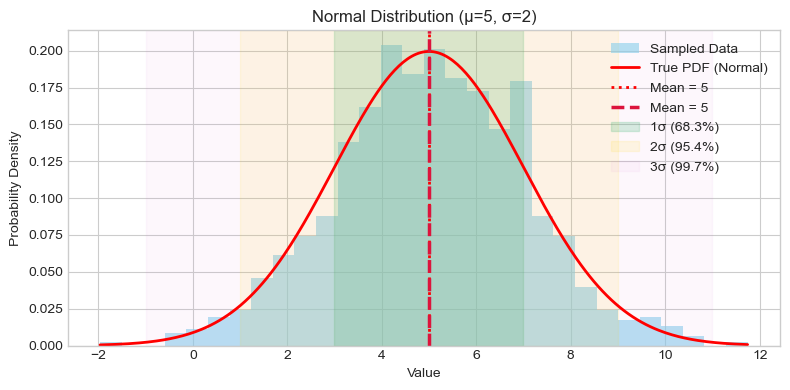

In [4]:
# Use a visually appealing style
plt.style.use('seaborn-v0_8-whitegrid')

# Step 1: Generate random data from a normal distribution
mu = 5      # mean
sigma = 2   # standard deviation
data = np.random.normal(loc=mu, scale=sigma, size=1000)

# Step 2: Plot histogram and overlay the true PDF
plt.figure(figsize=(8, 4))
count, bins, _ = plt.hist(data, bins=30, density=True, alpha=0.6, color='skyblue', label='Sampled Data')

# Step 3: Plot theoretical PDF
x = np.linspace(min(bins), max(bins), 300)
pdf = norm.pdf(x, mu, sigma)
plt.plot(x, pdf, 'r', lw=2, label='True PDF (Normal)')

# Step 4: Add mean and sigma intervals
plt.axvline(mu, color='r', linestyle='dotted', linewidth=2, label=f'Mean = {mu}')

# Step 5: Add mean line
plt.axvline(mu, color='crimson', linestyle='--', linewidth=2.5, label=f'Mean = {mu}')

# Step 6: Shade sigma intervals
plt.axvspan(mu - sigma, mu + sigma, alpha=0.2, color='mediumseagreen', label='1σ (68.3%)')
plt.axvspan(mu - 2*sigma, mu + 2*sigma, alpha=0.1, color='gold', label='2σ (95.4%)')
plt.axvspan(mu - 3*sigma, mu + 3*sigma, alpha=0.05, color='orchid', label='3σ (99.7%)')

plt.title(f"Normal Distribution (μ={mu}, σ={sigma})")
plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 1.2.3 - Random Variables

A **random variable** describes the hidden state of the system.  
A random variable is a set of possible values from a random experiment.

The random variable can be continuous or discrete:

- A **continuous random variable** can take any value within a specific range,  
  such as battery charge time or marathon race time.
- A **discrete random variable** is countable,  
  such as the number of website visitors or the number of students in the class.

The random variable is described by the **probability density function**.  
In this text, the PDF is characterized by:

- $\mu_x$ — the **mean** of the sequence of measurements  
- $\sigma_x^2$ — the **variance** of the sequence of measurements

Sample outcomes of the discrete random variable (die rolls):
[2 6 3 2 6 4 4 5 1 5]


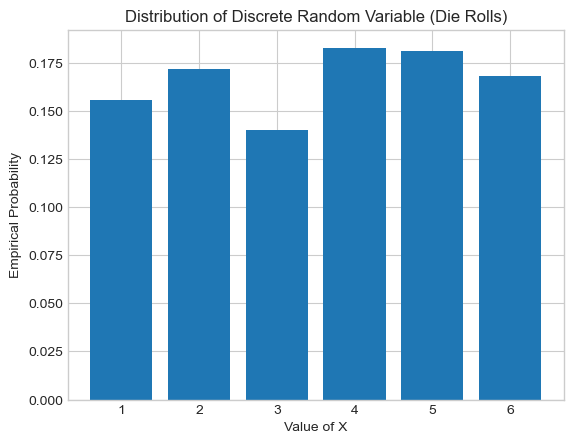

In [5]:
# Define random process: rolling a 6-sided die 1000 times
outcomes = np.random.choice([1, 2, 3, 4, 5, 6], size=1000)

# View first few outcomes (realizations of the random variable)
print("Sample outcomes of the discrete random variable (die rolls):")
print(outcomes[:10])

# Estimate empirical probabilities
plt.hist(outcomes, bins=np.arange(1, 8)-0.5, density=True, rwidth=0.8)
plt.xticks(np.arange(1, 7))
plt.title("Distribution of Discrete Random Variable (Die Rolls)")
plt.xlabel("Value of X")
plt.ylabel("Empirical Probability")
#plt.grid(True)
plt.show()

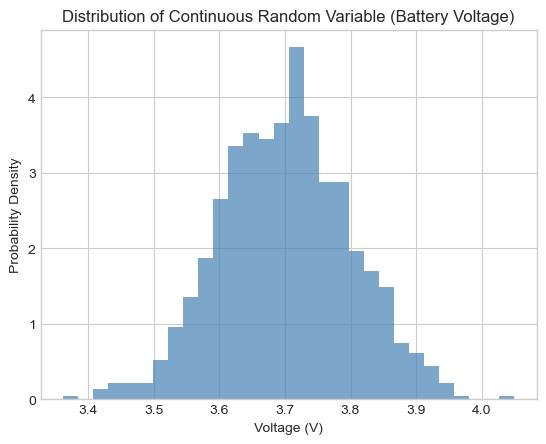

In [6]:
# Random variable: simulated battery voltage readings (normally distributed)
mu = 3.7      # volts
sigma = 0.1   # sensor noise

voltages = np.random.normal(loc=mu, scale=sigma, size=1000)

# Plot
plt.hist(voltages, bins=30, density=True, alpha=0.7, color='steelblue')
plt.title("Distribution of Continuous Random Variable (Battery Voltage)")
plt.xlabel("Voltage (V)")
plt.ylabel("Probability Density")
plt.grid(True)
plt.show()

A **random variable** is not a single number — it's a function that maps outcomes from a random process to numerical values.

Each call to `np.random.normal()` or `np.random.choice()` returns a **realization** of the random variable.

By collecting many realizations, we can **observe its empirical distribution** and estimate properties like mean, variance, etc.

### 1.2.4 - Estimate, Accuracy and Precision

- An **estimate** is a value computed from measurements or models that approximates a hidden or unknown true value.
- **Accuracy** refers to how close the estimate is to the true value (i.e., low bias).
- **Precision** refers to how consistent repeated estimates are (i.e., low variance).

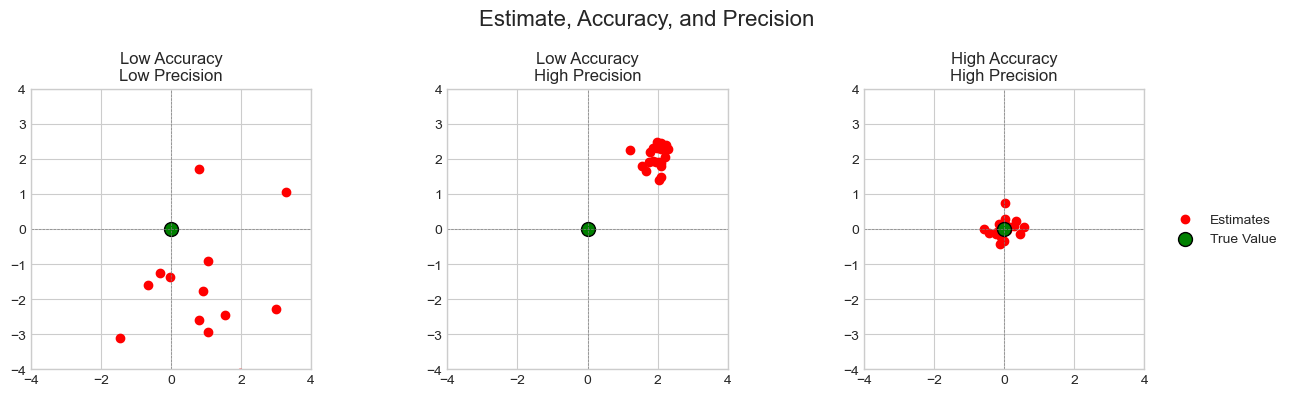

In [7]:
# Set the true value (e.g., position)
true_value = np.array([0, 0])

# Helper to generate synthetic estimates
def generate_estimates(center, spread, n=20):
    return np.random.normal(loc=center, scale=spread, size=(n, 2))

# Simulated estimate clusters
np.random.seed(42)
low_acc_low_prec = generate_estimates(center=[2, -2], spread=2.0)
low_acc_high_prec = generate_estimates(center=[2, 2], spread=0.3)
high_acc_high_prec = generate_estimates(center=true_value, spread=0.3)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(14, 4))
titles = ['Low Accuracy\nLow Precision', 'Low Accuracy\nHigh Precision', 'High Accuracy\nHigh Precision']
clusters = [low_acc_low_prec, low_acc_high_prec, high_acc_high_prec]

for ax, cluster, title in zip(axs, clusters, titles):
    ax.scatter(cluster[:, 0], cluster[:, 1], c='red', label='Estimates')
    ax.scatter(*true_value, c='green', s=100, label='True Value', edgecolors='black')
    ax.axhline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.axvline(0, color='gray', linestyle='--', linewidth=0.5)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)
    ax.set_title(title)
    ax.set_aspect('equal')

plt.legend(loc='center left', bbox_to_anchor=(1.05, 0.5))
plt.suptitle("Estimate, Accuracy, and Precision", fontsize=16)
plt.tight_layout()
plt.show()

In this simulation:
- The left plot shows a system with **high bias** and **high variance** (low accuracy, low precision).
- The middle plot has **high bias** but **low variance** (low accuracy, high precision).
- The right plot shows a system with **low bias** and **low variance** (high accuracy, high precision).

## 1.3 - The g, g-h and g-h-k filter

### 1.3.1 - The alpha/g filter

In [8]:
def alpha_filter(z_measurements, x0, alpha=None, debug_mode=False):
    """
    Applies an alpha (gain) filter to a sequence of scalar measurements.

    Update equation:
        x_n = x_n_prev + alpha_n * (z_n - x_n_prev)
    
    Parameters
    ----------
    z_measurements (list of float) : The noisy measurements z_n
    x0 (float)                     : Initial estimate of the state
    alpha (callable or None)       : If None, uses alpha_n = 1/n (Becker’s example, Adaptive gain).
                                     Otherwise, a constant gain of alpha is applied in each iteration
    debug_mode (bool)              : If True, also returns predictions and alpha history
    
    Returns
    -------
    estimates (list of float)   : Filtered state estimates [x0, x1, ..., xN]
    predictions (list of float) : Prior state predictions before update      (when debug_mode=True)
    alphas (list of float)      : Alpha gain at each step                    (when debug_mode=True)
    """
    alphas = []
    estimates = []
    predictions = []

    x_prev = x0
    
    for i, z in enumerate(z_measurements, start=1):
        
        alpha_n = (1 / i) if alpha is None else alpha  # set alpha_n for each iteration (adaptive or fixed gain)

        x_new = x_prev + alpha_n * (z - x_prev)        # state update equation
        x_pred = x_new                                 # the prediction state is the current state estimate

        estimates.append(x_new)

        if debug_mode:
            predictions.append(x_pred)
            alphas.append(alpha_n)

        x_prev = x_new

    #print((estimates))
    #print((predictions))
    #print((alphas))
    
    if debug_mode:
        return estimates, predictions, alphas

    return estimates

n =  1	| alpha_1 = 1.000 	| z_1 =   996 	| estimate_(1, 1) = 996.00 	| predictions_(2, 1) = 996.000
n =  2	| alpha_2 = 0.500 	| z_2 =   994 	| estimate_(2, 2) = 995.00 	| predictions_(3, 2) = 995.000
n =  3	| alpha_3 = 0.333 	| z_3 =  1021 	| estimate_(3, 3) = 1003.67 	| predictions_(4, 3) = 1003.667
n =  4	| alpha_4 = 0.250 	| z_4 =  1000 	| estimate_(4, 4) = 1002.75 	| predictions_(5, 4) = 1002.750
n =  5	| alpha_5 = 0.200 	| z_5 =  1002 	| estimate_(5, 5) = 1002.60 	| predictions_(6, 5) = 1002.600
n =  6	| alpha_6 = 0.167 	| z_6 =  1010 	| estimate_(6, 6) = 1003.83 	| predictions_(7, 6) = 1003.833
n =  7	| alpha_7 = 0.143 	| z_7 =   983 	| estimate_(7, 7) = 1000.86 	| predictions_(8, 7) = 1000.857
n =  8	| alpha_8 = 0.125 	| z_8 =   971 	| estimate_(8, 8) = 997.12 	| predictions_(9, 8) = 997.125
n =  9	| alpha_9 = 0.111 	| z_9 =   993 	| estimate_(9, 9) = 996.67 	| predictions_(10, 9) = 996.667
n = 10	| alpha_10 = 0.100 	| z_10 =  1023 	| estimate_(10, 10) = 999.30 	| predictions_(1

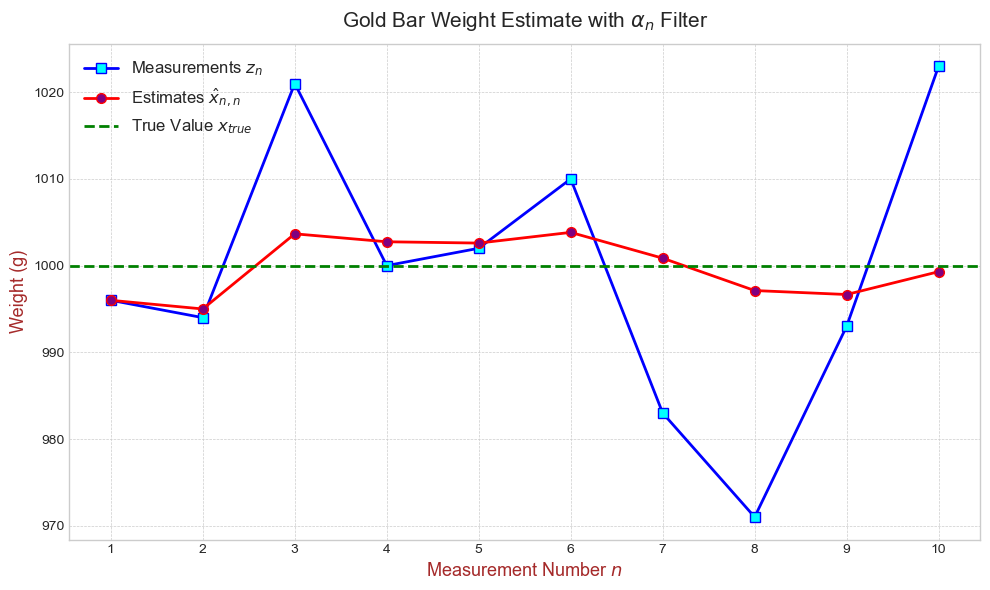

In [9]:
# Simulated noisy gold bar measurements (in grams)
z = [996, 994, 1021, 1000, 1002, 1010, 983, 971, 993, 1023]  # measurements z_n
x0 = 1000  # initial estimate (could also be 995 to match)

estimates, predictions, alphas = alpha_filter(z, x0, debug_mode=True)

# Print results in clean LaTeX-style variable names
for n in range(0, len(estimates)):
    print(f"n = {n+1:2d}\t| alpha_{n+1} = {alphas[n]:.3f} \t| z_{n+1} = {z[n]:5} \t| estimate_{n+1, n+1} = {estimates[n]:.2f} \t| predictions_{n+2, n+1} = {predictions[n]:.3f}")
print("")

# Plot
plt.figure(figsize=(10, 6))

x_range = range(1, len(z)+1)

# Plot measurements
plt.plot(x_range, z, 'bs-', linewidth=2, markersize=7, markerfacecolor='cyan', label='Measurements $z_n$')

# Plot estimates
plt.plot(x_range, estimates, 'ro-', linewidth=2, markersize=7, markerfacecolor='purple', label='Estimates $\\hat{x}_{n,n}$')

# Plot true value
plt.axhline(1000, color='green', linestyle='--', linewidth=2, label='True Value $x_{true}$')

# Axis labels and title
plt.xlabel("Measurement Number $n$", fontsize=13, color='brown')
plt.ylabel("Weight (g)", fontsize=13, color='brown')
plt.title("Gold Bar Weight Estimate with $\\alpha_n$ Filter", fontsize=15, pad=12)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.xticks(range(1, len(z)+1))
plt.tight_layout()
plt.show()

### 1.3.2 - The alpha-beta/g-h filter

The $\alpha - \beta$ filter is a 1D tracking algorithm that estimates both position and velocity of a moving object, assuming nearly constant velocity.

It uses:
- **$\alpha$** for position correction
- **$\beta$** for velocity correction
- A fixed time interval $\Delta t$ between measurements

It consists of two main steps:
1. **Correction (Update):** Incorporate the new measurement.
2. **Prediction (Extrapolation):** Forecast the next state.

It is widely used in radar tracking, low-cost embedded systems, and robotics where computational simplicity is preferred over complex filters like the Kalman Filter.

In [10]:
def alpha_beta_filter(z_measurements, x0, v0, alpha, beta, dt, debug_mode=False):
    """
    Alpha-Beta filter for 1D constant-velocity tracking.

    alpha-beta Tracl Update equations:
        x_n = x_n_prev + alpha_n * (z_n - x_n_prev)
        v_n = v_n_prev + beta_n * ((z_n - x_n_prev)/dt)
    
    Parameters
    ----------
    z_measurements (list of float) : The noisy measurements z_n
    x0 (float)                     : Initial estimate of the state
    alpha (float)                  : constant gain of alpha is applied in each iteration
    beta (float)                   : constant gain of beta is applied in each iteration
    dt (float)                     : Time step between measurements.
    debug_mode (bool)              : If True, also returns predictions and alpha history
    
    Returns
    -------
    x_estimates (list of float) : Filtered position estimates.
    v_estimates (list of float) : Filtered velocity estimates.
    x_preds (list of float)   : Prior position predictions.                       (Optional if debug_mode=True)
    v_preds (list of float)   : Prior velocity predictions.                       (Optional if debug_mode=True)
    residuals (list of float) : Innovation/residuals at each step (z - x_pred).   (Optional if debug_mode=True)
    """
    x_estimates = []
    v_estimates = []

    if debug_mode:
        x_preds = []
        v_preds = []
        residuals = []

    x = x0
    v = v0

    # Initial Prediction prior to iterative process
    x_pred = x + v * dt
    v_pred = v

    for z in z_measurements:

        # Innovation aka residual
        r = z - x_pred

        # Update
        x = x_pred + alpha * r
        v = v_pred + beta * (r /dt)

        # Predict for next iteration
        x_pred = x + v * dt
        v_pred = v

        x_estimates.append(x)
        v_estimates.append(v)

        if debug_mode:
            x_preds.append(x_pred)
            v_preds.append(v_pred)
            residuals.append(r)

        

    if debug_mode:
        return x_estimates, v_estimates, x_preds, v_preds, residuals
    else:
        return x_estimates, v_estimates

n =  1	| z_1 = 30171 	| x_est_(1, 1) = 30194.20 	| v_est_(1, 1) = 39.42  	| x_pred_(2, 1) = 30391.300 	| v_pred_(2, 1) = 39.420
n =  2	| z_2 = 30353 	| x_est_(2, 2) = 30383.64 	| v_est_(2, 2) = 38.65  	| x_pred_(3, 2) = 30576.910 	| v_pred_(3, 2) = 38.654
n =  3	| z_3 = 30756 	| x_est_(3, 3) = 30612.73 	| v_est_(3, 3) = 42.24  	| x_pred_(4, 3) = 30823.907 	| v_pred_(4, 3) = 42.236
n =  4	| z_4 = 30799 	| x_est_(4, 4) = 30818.93 	| v_est_(4, 4) = 41.74  	| x_pred_(5, 4) = 31027.614 	| v_pred_(5, 4) = 41.738
n =  5	| z_5 = 31018 	| x_est_(5, 5) = 31025.69 	| v_est_(5, 5) = 41.55  	| x_pred_(6, 5) = 31233.418 	| v_pred_(6, 5) = 41.545
n =  6	| z_6 = 31278 	| x_est_(6, 6) = 31242.33 	| v_est_(6, 6) = 42.44  	| x_pred_(7, 6) = 31454.520 	| v_pred_(7, 6) = 42.437
n =  7	| z_7 = 31276 	| x_est_(7, 7) = 31418.82 	| v_est_(7, 7) = 38.87  	| x_pred_(8, 7) = 31613.149 	| v_pred_(8, 7) = 38.867
n =  8	| z_8 = 31379 	| x_est_(8, 8) = 31566.32 	| v_est_(8, 8) = 34.18  	| x_pred_(9, 8) = 31737.237 	|

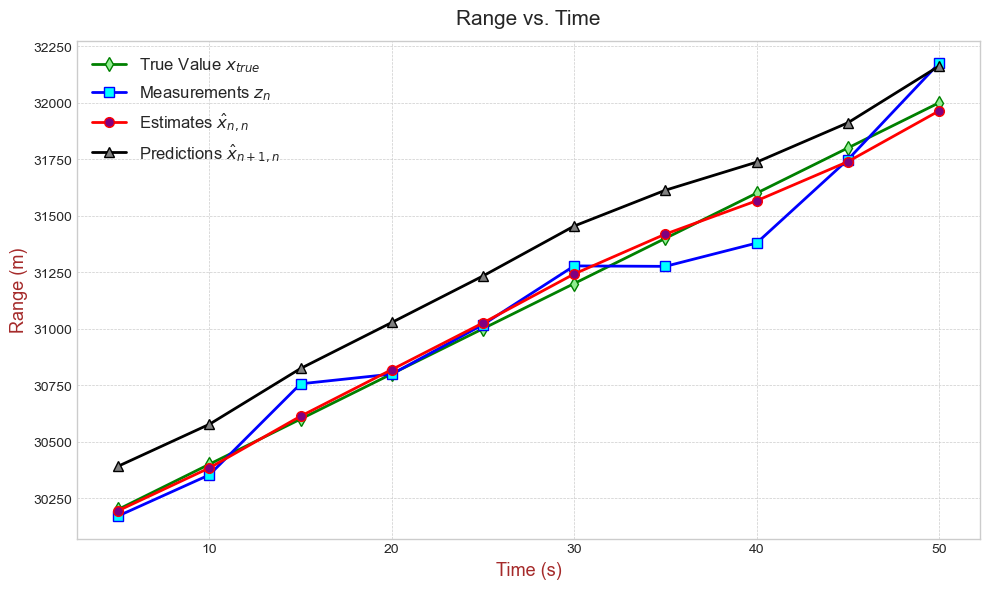

In [11]:
'''
Example 2 - Tracking the constant velocity of a UAV in 1-D
'''

z = [30171, 30353, 30756, 30799, 31018, 31278, 31276, 31379, 31748, 32175]
x0 = 30000
v0 = 40
alpha = 0.2
beta = 0.1
dt = 5

# Assume that true range values ideally follow the simple kienamtic eqn
true_range = [(x0 + v0*dt*i) for i in range(1, len(z)+1)] 
#print(true_range)

x_est, v_est, x_pred, v_pred, _ = alpha_beta_filter(z, x0, v0, alpha, beta, dt, debug_mode=True)

# Print results in clean LaTeX-style variable names
for n in range(0, len(estimates)):
    print(f"n = {n+1:2d}\t| z_{n+1} = {z[n]:5} \t| x_est_{n+1, n+1} = {x_est[n]:.2f} \t| v_est_{n+1, n+1} = {v_est[n]:.2f}  \t| x_pred_{n+2, n+1} = {x_pred[n]:.3f} \t| v_pred_{n+2, n+1} = {v_pred[n]:.3f}")
print("")

# Plot
plt.figure(figsize=(10, 6))

x_range = [i * dt for i in range(1, len(z) + 1)]

# Plot true value
plt.plot(x_range, true_range, color='green', linestyle='-', linewidth=2, marker='d', markersize=7, markerfacecolor='lightgreen', label='True Value $x_{true}$')

# Plot measurements
plt.plot(x_range, z, 'bs-', linewidth=2, markersize=7, markerfacecolor='cyan', label='Measurements $z_n$')

# Plot estimates
plt.plot(x_range, x_est, 'ro-', linewidth=2, markersize=7, markerfacecolor='purple', label='Estimates $\\hat{x}_{n,n}$')

# Plot predictions
plt.plot(x_range, x_pred, 'k^-', linewidth=2, markersize=7, markerfacecolor='grey', label='Predictions $\\hat{x}_{n+1,n}$')

# Axis labels and title
plt.xlabel("Time (s)", fontsize=13, color='brown')
plt.ylabel("Range (m)", fontsize=13, color='brown')
plt.title("Range vs. Time", fontsize=15, pad=12)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

4
7
[30250, 30500, 30750, 31000, 31350.0, 31900.0, 32650.0, 33600.0, 34750.0, 36100.0]
n =  1	| z_1 = 30221 	| x_est_(1, 1) = 30244.20 	| v_est_(1, 1) = 49.42  	| x_pred_(2, 1) = 30491.300 	| v_pred_(2, 1) = 49.420
n =  2	| z_2 = 30453 	| x_est_(2, 2) = 30483.64 	| v_est_(2, 2) = 48.65  	| x_pred_(3, 2) = 30726.910 	| v_pred_(3, 2) = 48.654
n =  3	| z_3 = 30906 	| x_est_(3, 3) = 30762.73 	| v_est_(3, 3) = 52.24  	| x_pred_(4, 3) = 31023.907 	| v_pred_(4, 3) = 52.236
n =  4	| z_4 = 30999 	| x_est_(4, 4) = 31018.93 	| v_est_(4, 4) = 51.74  	| x_pred_(5, 4) = 31277.614 	| v_pred_(5, 4) = 51.738
n =  5	| z_5 = 31368 	| x_est_(5, 5) = 31295.69 	| v_est_(5, 5) = 53.55  	| x_pred_(6, 5) = 31563.418 	| v_pred_(6, 5) = 53.545
n =  6	| z_6 = 31978 	| x_est_(6, 6) = 31646.33 	| v_est_(6, 6) = 61.84  	| x_pred_(7, 6) = 31955.520 	| v_pred_(7, 6) = 61.837
n =  7	| z_7 = 32526 	| x_est_(7, 7) = 32069.62 	| v_est_(7, 7) = 73.25  	| x_pred_(8, 7) = 32435.849 	| v_pred_(8, 7) = 73.247
n =  8	| z_8 = 33

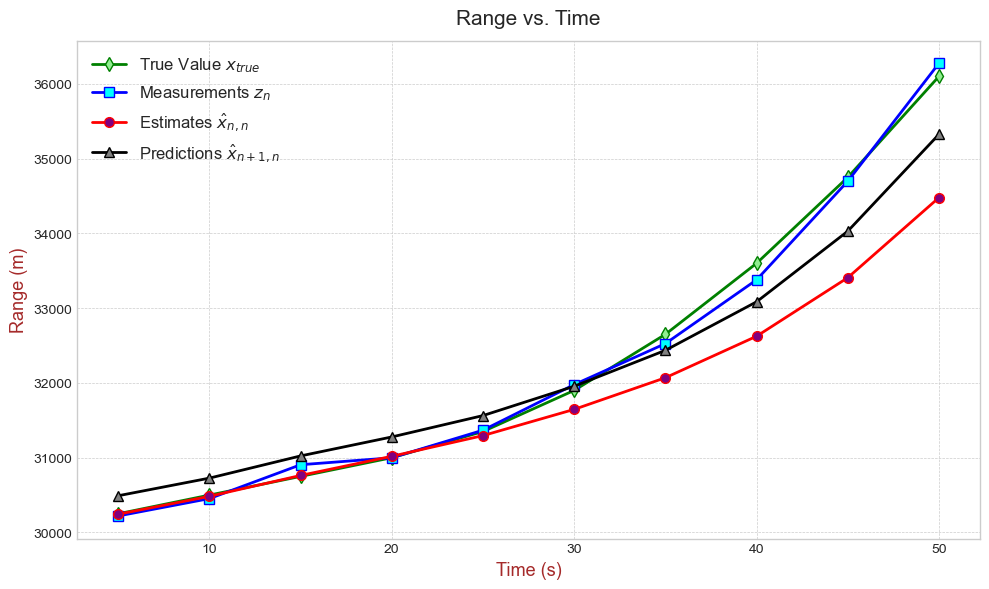

In [12]:
'''
Example 3 - Tracking an accelerating aircraft
'''

z = [30221, 30453, 30906, 30999, 31368, 31978, 32526, 33379, 34698, 36275]
x0 = 30000
v0 = 50
alpha = 0.2
beta = 0.1
dt = 5

# Total simulation time = 55 s → 55 / dt = 11 time steps
t1 = 20
n1 = t1 // dt    # Number of steps in phase 1
print(n1)
n2 = (55 - t1) // dt  # Number of steps in phase 2
print(n2)

# Phase 1: constant velocity (0–20s)
true_range_phase1 = [x0 + v0 * dt * i for i in range(1, n1 + 1)]

# Phase 2: accelerated motion (20-55s)
x1 = x0 + v0 * t1     # Position at start of acceleration
v1 = v0               # Velocity at start of acceleration
a = 8                 # const. acceleration of 8m/s^2
#print(x1)
#print(v1)

true_range_phase2 = [x1 + v1 * (dt * (i - n1)) + 0.5 * a * (dt * (i - n1))**2 for i in range(n1+1, n1 + n2)]

# Combine both phases
true_range = true_range_phase1 + true_range_phase2
print(true_range)

x_est, v_est, x_pred, v_pred, _ = alpha_beta_filter(z, x0, v0, alpha, beta, dt, debug_mode=True)

# Print results in clean LaTeX-style variable names
for n in range(0, len(estimates)):
    print(f"n = {n+1:2d}\t| z_{n+1} = {z[n]:5} \t| x_est_{n+1, n+1} = {x_est[n]:.2f} \t| v_est_{n+1, n+1} = {v_est[n]:.2f}  \t| x_pred_{n+2, n+1} = {x_pred[n]:.3f} \t| v_pred_{n+2, n+1} = {v_pred[n]:.3f}")
print("")

# Plot
plt.figure(figsize=(10, 6))

x_range = [i * dt for i in range(1, len(z) + 1)]

# Plot true value
plt.plot(x_range, true_range, color='green', linestyle='-', linewidth=2, marker='d', markersize=7, markerfacecolor='lightgreen', label='True Value $x_{true}$')

# Plot measurements
plt.plot(x_range, z, 'bs-', linewidth=2, markersize=7, markerfacecolor='cyan', label='Measurements $z_n$')

# Plot estimates
plt.plot(x_range, x_est, 'ro-', linewidth=2, markersize=7, markerfacecolor='purple', label='Estimates $\\hat{x}_{n,n}$')

# Plot predictions
plt.plot(x_range, x_pred, 'k^-', linewidth=2, markersize=7, markerfacecolor='grey', label='Predictions $\\hat{x}_{n+1,n}$')

# Axis labels and title
plt.xlabel("Time (s)", fontsize=13, color='brown')
plt.ylabel("Range (m)", fontsize=13, color='brown')
plt.title("Range vs. Time", fontsize=15, pad=12)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

[50, 50, 50, 50, 90, 130, 170, 210, 250, 290]


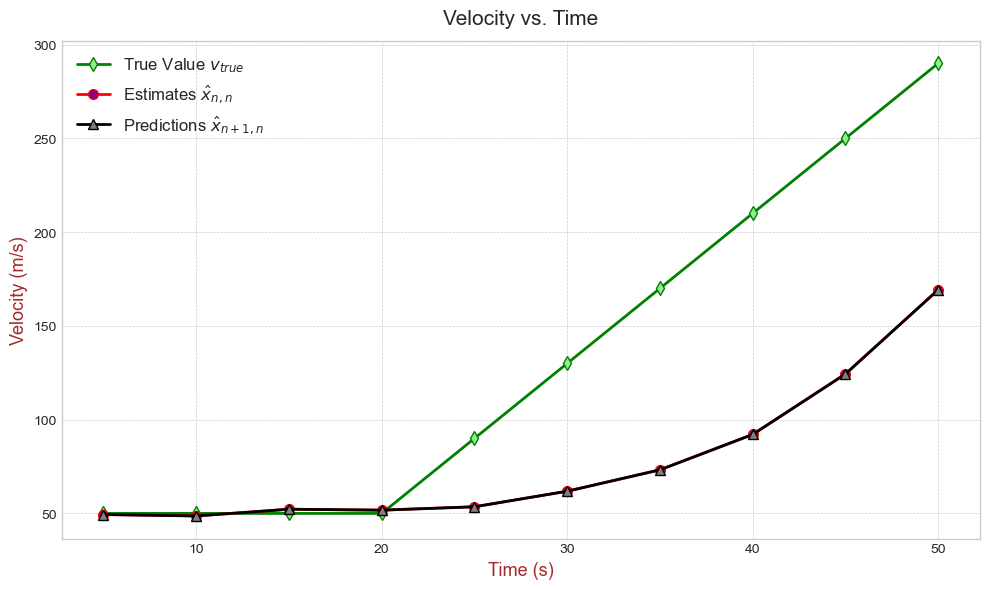

In [13]:
# Phase 1: constant velocity → just repeat v0
true_vel_phase1 = [v0 for _ in range(1, n1)]

# Phase 2: accelerating → v = v1 + a * Δt
true_vel_phase2 = [v1 + a * dt * (i - n1) for i in range(n1, n1 + n2)]

# Combine both phases
true_vel = true_vel_phase1 + true_vel_phase2
print(true_vel)

# Plot
plt.figure(figsize=(10, 6))

x_range = [i * dt for i in range(1, len(z) + 1)]

# Plot true value
plt.plot(x_range, true_vel, color='green', linestyle='-', linewidth=2, marker='d', markersize=7, markerfacecolor='lightgreen', label='True Value $v_{true}$')


# Plot estimates
plt.plot(x_range, v_est, 'ro-', linewidth=2, markersize=7, markerfacecolor='purple', label='Estimates $\\hat{x}_{n,n}$')

# Plot predictions
plt.plot(x_range, v_pred, 'k^-', linewidth=2, markersize=7, markerfacecolor='grey', label='Predictions $\\hat{x}_{n+1,n}$')

# Axis labels and title
plt.xlabel("Time (s)", fontsize=13, color='brown')
plt.ylabel("Velocity (m/s)", fontsize=13, color='brown')
plt.title("Velocity vs. Time", fontsize=15, pad=12)

# Legend and grid
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### 1.3.3 - The alpha-beta-gamma/g-h-k filter